In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import json
import random

from subword_prompt_templates.MultiChoicePrompts import MultiChoicePrompts
from subword_prompt_templates.ClassificationPrompts import ClassificationPrompts

from utils import helpers

from openai import OpenAI

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
models = ['MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1', 'allenai/OLMo-7B-Instruct', 'meta-llama/Llama-3-8b-chat-hf']
prompts = ['zero_shot', 'one_shot', 'few_shot', 'CoT-one', 'CoT-few', 'decomposite']
dataset = pd.read_csv(r"datasets\dataset_for_evaluation.csv", index_col=0)

TOGETHER_API_KEY = os.environ.get("TOGETHER_API_KEY")
client = OpenAI(api_key=TOGETHER_API_KEY, base_url='https://api.together.xyz/v1')

random.seed(42)

In [4]:
results = []
mcp = MultiChoicePrompts()
ynp = ClassificationPrompts()
for model in models:
    for prompt_type in prompts:
        if '-' in prompt_type: # for CoT
            prompt_technique, shot = prompt_type.split('-')
            kwargs = {'shot': shot}
        else:
            prompt_technique = prompt_type
            kwargs = {}
        for row in dataset.itertuples():
            wrong_choices = json.loads(row.Mulitple_Options.replace(" ", ", ").replace("'", '"'))
            correct_choice = row.Word
            choices = wrong_choices + [correct_choice]
            random.shuffle(choices)
            correct_choice_letter = chr(choices.index(correct_choice) + 65)
            multi_question = mcp.generate(prompt_technique, row.Category, *choices, **kwargs)
            yes_question = ynp.generate(prompt_technique, row.Category, row.Word, **kwargs)
            no_question = ynp.generate(prompt_technique, row.Category, random.choice(wrong_choices), **kwargs)
            multi_answer = helpers.generate_llm_response(client, multi_question, model)
            yes_answer = helpers.generate_llm_response(client, yes_question, model)
            no_answer = helpers.generate_llm_response(client, no_question, model)
            multi_eval = helpers.evaluate_response('multi', multi_answer, correct_choice_letter)
            yes_eval = helpers.evaluate_response('classification', yes_answer, "Yes")
            no_eval = helpers.evaluate_response('classification', no_answer, "No")
            results.append((model, prompt_type, 'multi', multi_question, multi_answer, correct_choice_letter, multi_eval))
            results.append((model, prompt_type, 'classification', yes_question, yes_answer, "yes", yes_eval))
            results.append((model, prompt_type, 'classification', no_question, no_answer, "No", no_eval))
            break
        # break
results_df = pd.DataFrame(results, columns=["Model", "Prompt Type", "Question type", "Question", "LLM Response", "Correct answer", "Eval"])
results_df.to_csv("check_evaluate.csv")
results_df.head()

,Model,Prompt Type,Question type,Question,LLM Response,Correct answer,Eval
0,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,zero_shot,multi,Subword is a standalone word that exists withi...,C. incredible\n\nExplanation:\nincredible con...,C,True
1,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,zero_shot,classification,Subword is a standalone word that exists withi...,"Yes, the word ""incredible"" contains the subwo...",yes,True
2,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,zero_shot,classification,Subword is a standalone word that exists withi...,No.,No,True
3,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,one_shot,multi,### example question ###\nSubword is a standal...,"B. incredible\n\n(Explanation: The subword ""c...",B,True
4,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,one_shot,classification,### example question ###\nSubword is a standal...,Yes.,yes,True


# multi-choice results

Prompt Type,zero_shot,one_shot,few_shot,CoT-one,CoT-few,decomposite
Model,,,,,,
MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,1.0,1.0,1.0,1.0,1.0,1.0
allenai/OLMo-7B-Instruct,0.0,0.0,0.0,0.0,1.0,0.0
meta-llama/Llama-3-8b-chat-hf,0.0,1.0,0.0,0.0,0.0,0.0


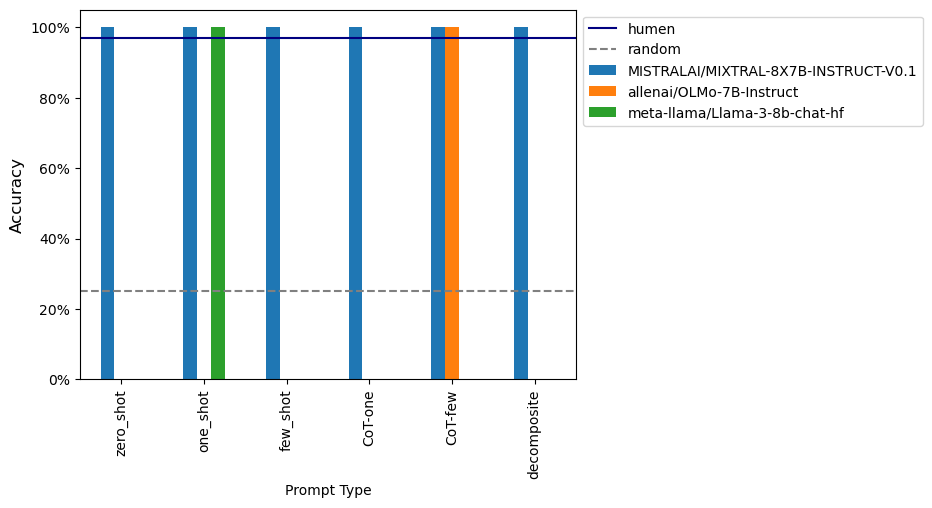

In [9]:
multi_pv = results_df[results_df['Question type']=='multi'].pivot_table(index='Model', columns='Prompt Type', values='Eval', aggfunc='mean')[prompts]
display(multi_pv)
helpers.plot_results(multi_pv, radnom_line=0.25) # for now the lines are not really correct

# Yes\No results

Prompt Type,zero_shot,one_shot,few_shot,CoT-one,CoT-few,decomposite
Model,,,,,,
MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,1.0,0.5,1.0,0.5,1.0,1.0
allenai/OLMo-7B-Instruct,0.5,0.5,0.5,0.5,0.5,0.5
meta-llama/Llama-3-8b-chat-hf,0.5,0.5,1.0,0.5,1.0,0.5


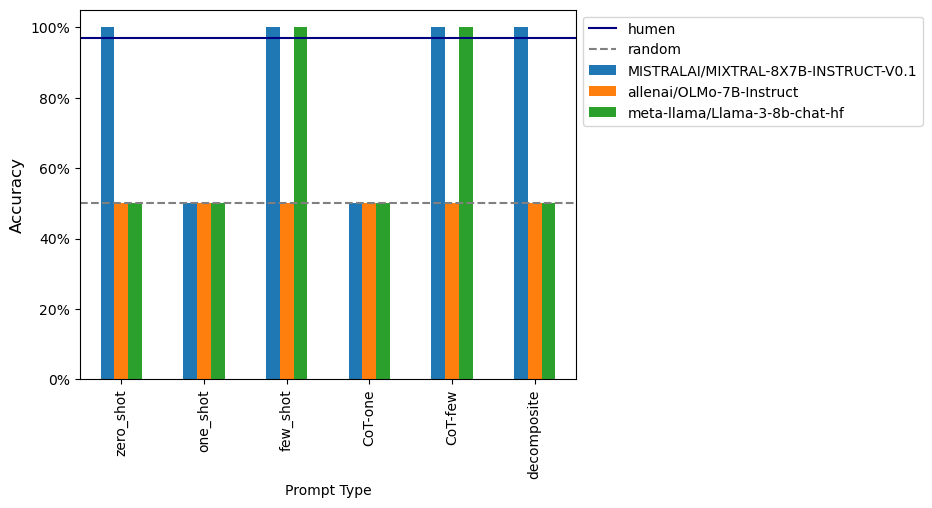

In [6]:
classification_pv = results_df[results_df['Question type']=='classification'].pivot_table(index='Model', columns='Prompt Type', values='Eval', aggfunc='mean')[prompts]
display(classification_pv)
helpers.plot_results(classification_pv, radnom_line=0.5) # for now the lines are not really correct

# tests

In [7]:
# import re

# gold_response = "A"

# pattern = rf'\W*{re.escape(gold_response)}\W*\b'

# # Example strings to test
# test_strings = ["A.", "A)", "[A]", "A", "An", "A+", "A*", "A ", " A ", "The A", "A is the correct answer"]

# # Check each string
# for string in test_strings:
#     if re.match(pattern, string):
#         print(f"'{string}' starts with '{gold_response}'")
#     else:
#         print(f"'{string}' does not match the pattern.")

In [8]:
# import re

# gold_response = "Yes"

# pattern = rf'\W*{gold_response}\b'

# # Example strings to test
# test_strings = ["Yes.", "Yes)", "[Yes]", "Yes", "Yess", "Yes ", " Yes ", "The Yes", "Yes is the correct answer"]

# # Check each string
# for string in test_strings:
#     if re.match(pattern, string):
#         print(f"'{string}' starts with '{gold_response}'")
#     else:
#         print(f"'{string}' does not match the pattern.")
        